# Tarea 2, pregunta 3: "Encoder-Decoder sobre Texto"

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Modificar estilos de jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

# Tamaño fuente matplotlib
font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

In [2]:
# Se importa el dataset
import pandas as pd
df = pd.read_csv("dataset_3/spa.txt", sep="\t", names=["Source","Target"])
display(df.head())
df.shape

,Source,Target
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


(123376, 2)

## a)
Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

In [3]:
display(df.tail())

,Source,Target
123371,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
123372,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
123373,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
123374,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."
123375,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...


## b)
Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.

In [4]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where =="target":
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))

In [5]:
from sklearn.model_selection import train_test_split
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=10000, random_state=22)

# Se van a seleccionar 35000 elementos
idx = np.random.choice(np.arange(len(X_train_l)), 25000, replace=False)
X_train_l = np.asarray(X_train_l)[idx]
Y_train_l = np.asarray(Y_train_l)[idx]

X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=10000, random_state=22)

## c)
Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?

In [6]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]

vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1 : w for i, w in enumerate(vocab_target)}
n_words_t = len(vocab_target)

Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

In [7]:
""" Source/input data """

def convert_text_to_index(X, Y, vocabulary):
    transformed_data = list()
    for i in range(len(X)):
        words_in_vocabulary = True
        trasnformed_sentence = []
        for word in X[i]:
            if word in vocabulary:
                trasnformed_sentence.append(vocabulary[word])
            else:
                words_in_vocabulary = False
                break
        if words_in_vocabulary:
            transformed_data.append(trasnformed_sentence)
            
    return transformed_data
            
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_val = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]

# dataX_train = convert_text_to_index(X_train_l, word2idx_s)
# dataX_valid = convert_text_to_index(X_val_l, word2idx_s)
# dataX_test = convert_text_to_index(X_test_l, word2idx_s)

""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_val = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 

Se podría evitar generando el vocabulario a partir de TODO el dataset antes de particionarlo en los distintos conjuntos de entrenamiento, validación y testing. Así se debería disminuir la posibilidad de que una palabra no se encuentre presente en el vocabulario. Otra cosa que se podría hacer es disminuir la cantidad mínima de ocurrencias de una palabra para que esta sea conciderada en el vocabulario, actualmente está puesto en 3.

## d)
Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

In [8]:
from keras.preprocessing import sequence
""" INPUT DATA (Origin language) """
max_inp_length = max(map(len, dataX_train)) # Se saca el largo de la sentencia más larga
print("Largo max inp: ", max_inp_length)
word2idx_s["PAD"] = 0 #padding symbol
idx2word_s[0] = "PAD"
n_words_s += 1  

# Se procede a aplicar el padding
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_val = sequence.pad_sequences(dataX_val, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])

""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max out: ",max_out_length)
word2idx_t["PAD"] = 0 #padding symbol
idx2word_t[0] = "PAD"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_val = sequence.pad_sequences(dataY_val, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])

Using TensorFlow backend.


Largo max inp:  35
Largo max out:  37


## e)
Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [9]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

In [10]:
from keras.utils import to_categorical
# Y_train = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_train])
# Y_val = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_val])
# Y_test = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_test])

## f)
Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*). 

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, TimeDistributed, Dense, Dropout
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(CuDNNGRU(128, return_sequences=False))

from keras.layers import RepeatVector
model.add(RepeatVector(max_out_length)) #conection

# Decoder
model.add(CuDNNGRU(128, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           239600    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 35, 64)            31872     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               74496     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 37, 128)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 37, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 37, 64)            37248     
_________________________________________________________________
time

In [12]:
print(max_out_length)
print(Y_train.shape)
print(Y_val.shape)
Y_train = np.expand_dims(Y_train, axis=2)
Y_val = np.expand_dims(Y_val, axis=2)
Y_test = np.expand_dims(Y_test, axis=2)

37
(15000, 37)
(10000, 37)


In [13]:
Y_train[0][0]

array([1], dtype=int32)

Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_F = model.fit(X_train, Y_train, epochs=5, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

# model_F.compile(optimizer='adam', loss='categorical_crossentropy')
# history_F = model_F.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_val, Y_val), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 10s 675us/step - loss: 6.6124 - val_loss: 9.4440
Epoch 2/5
15000/15000 [==============================] - 7s 491us/step - loss: 5.6279 - val_loss: 10.3079
Epoch 3/5
15000/15000 [==============================] - 8s 505us/step - loss: 5.6196 - val_loss: 10.7470
Epoch 4/5
15000/15000 [==============================] - 8s 531us/step - loss: 5.6047 - val_loss: 11.1200
Epoch 5/5
15000/15000 [==============================] - 8s 520us/step - loss: 5.5834 - val_loss: 11.4041


/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


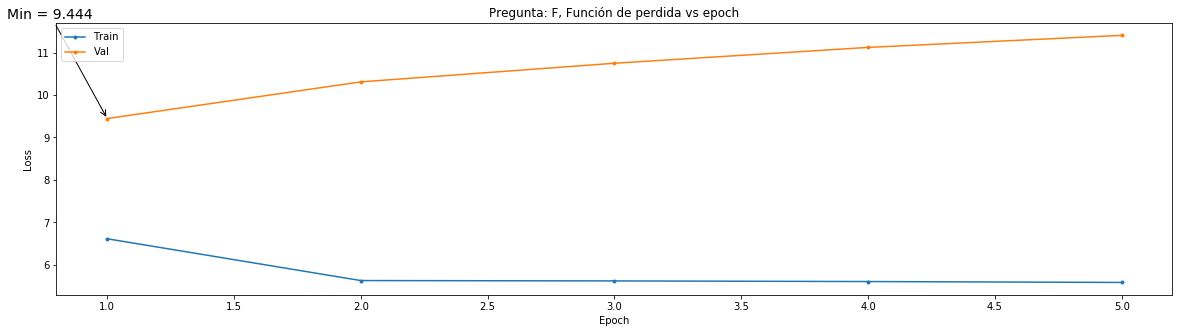

In [15]:
def chart_loss(history, epoch_number, question):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val') )
    plt.title("Pregunta: {}, Función de perdida vs epoch".format(question))

    max_index = np.argmin(history.history['val_loss'])
    max_value = history.history['val_loss'][max_index].round(3)
    plt.annotate('Min = {}'.format(max_value), xy=(max_index+1, max_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

chart_loss(history_F, 5, "F")

## g)
Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o desventaja de ésto *vs* la red neuronal.

In [16]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization()) #for stability
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model.add(RepeatVector(max_out_length)) #conection
model.add(CuDNNGRU(256, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 100)           239600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 256)           128256    
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 256)           1024      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 37, 256)           0         
__________

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_G = model.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 12s 827us/step - loss: 5.8178 - val_loss: 11.3870
Epoch 2/20
15000/15000 [==============================] - 11s 722us/step - loss: 5.3074 - val_loss: 12.3629
Epoch 3/20
15000/15000 [==============================] - 11s 716us/step - loss: 5.0281 - val_loss: 12.8794
Epoch 4/20
15000/15000 [==============================] - 11s 728us/step - loss: 4.7694 - val_loss: 13.3243
Epoch 5/20
15000/15000 [==============================] - 11s 758us/step - loss: 4.5328 - val_loss: 13.4219
Epoch 6/20
15000/15000 [==============================] - 11s 723us/step - loss: 4.2992 - val_loss: 13.7124
Epoch 7/20
15000/15000 [==============================] - 11s 715us/step - loss: 4.0734 - val_loss: 13.8706
Epoch 8/20
15000/15000 [==============================] - 11s 720us/step - loss: 3.8791 - val_loss: 13.9250
Epoch 9/

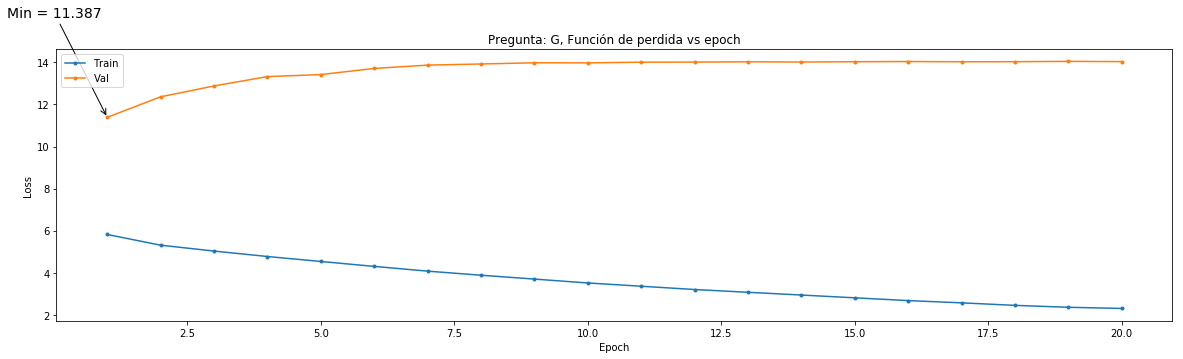

In [18]:
chart_loss(history_G, 20, "G")

## h)
Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.

In [21]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val

def show_predictions(model, number_of_examples = 5):
    n_s = number_of_examples
    idx = np.random.choice(np.arange(Y_val.shape[0]), size=n_s, replace=False)
    Y_pred = model.predict_classes(X_val[idx] )
    for i, n_sampled in enumerate(idx):
        text_input = [idx2word_s[p] for p in predict_words(X_val[n_sampled], data="source")]
        print("Texto source: ", ' '.join(text_input))
        text_real = [idx2word_t[p] for p in predict_words(Y_val[n_sampled,:,0], data="target")]
        print("Texto target real: ", ' '.join( text_real))
        text_sampled = [idx2word_t[p] for p in predict_words(Y_pred[i], data="target")]
        print("Texto target predicho: ", ' '.join(text_sampled))
        print('\n')
    
show_predictions(model)

Texto source:  i needed this
Texto target real:  yo necesitaba esto #end
Texto target predicho:  yo que esto #end


Texto source:  you didnt need to come here so early
Texto target real:  no venir aquí tan temprano #end
Texto target predicho:  no no aquí aquí aquí #end


Texto source:  ive spent way too much time thinking about this problem
Texto target real:  he pasado demasiado tiempo pensando sobre este problema #end
Texto target predicho:  este en de de este este este este este este #end


Texto source:  i found out about it on the news
Texto target real:  me de eso en las noticias #end
Texto target predicho:  estaba en en en en #end


Texto source:  have you ever played
Texto target real:  alguna vez #end
Texto target predicho:  has vez #end




## i)
Realice algún cambio esperando que mejore el modelo entrenado, luego vuelva a visualizar lo predicho por la red *vs* lo real. *Debido a lo costoso en entrenar puede optar por realizar solo un cambio pero que sea significativo*.

In [22]:
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization()) #for stability
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model.add(RepeatVector(max_out_length)) #conection
model.add(CuDNNGRU(256, return_sequences=True))
model.add(Dropout(0.5)) # Se añade Dropout esperando un efecto regularizador
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary() 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 100)           239600    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 256)           128256    
_________________________________________________________________
batch_normalization_3 (Batch (None, 35, 256)           1024      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
batch_normalization_4 (Batch (None, 35, 256)           1024      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
___________________________

In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_I = model.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 12s 813us/step - loss: 5.8786 - val_loss: 11.6411
Epoch 2/20
15000/15000 [==============================] - 12s 774us/step - loss: 5.4331 - val_loss: 12.4462
Epoch 3/20
15000/15000 [==============================] - 12s 769us/step - loss: 5.2229 - val_loss: 12.7879
Epoch 4/20
15000/15000 [==============================] - 12s 768us/step - loss: 5.0214 - val_loss: 13.3307
Epoch 5/20
15000/15000 [==============================] - 11s 749us/step - loss: 4.8592 - val_loss: 13.7004
Epoch 6/20
15000/15000 [==============================] - 11s 745us/step - loss: 4.7146 - val_loss: 13.7922
Epoch 7/20
15000/15000 [==============================] - 12s 774us/step - loss: 4.5846 - val_loss: 14.0753
Epoch 8/20
15000/15000 [==============================] - 11s 747us/step - loss: 4.4528 - val_loss: 14.1002
Epoch 9/20
15000/15000 [==============================] - 11s 725us/step - loss: 4.339

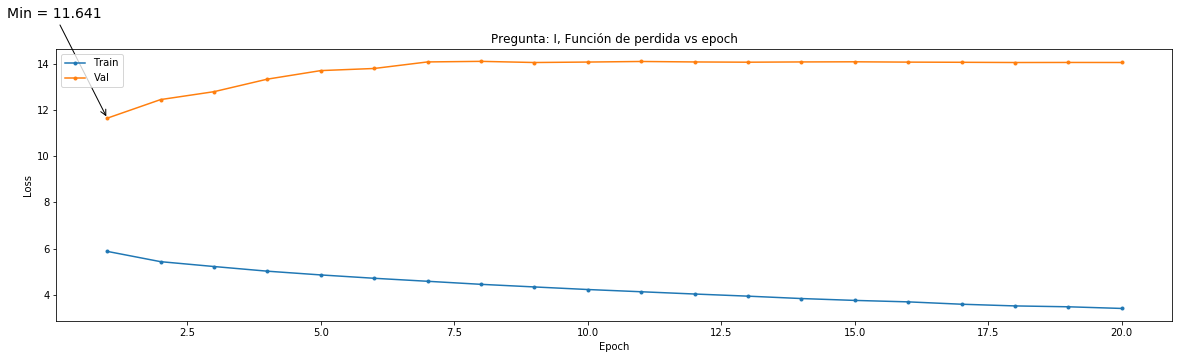

In [25]:
chart_loss(history_I, 20, "I")

In [26]:
show_predictions(model)

Texto source:  would you step aside
Texto target real:  hacerse a un lado #end
Texto target predicho:  un un #end


Texto source:  ill change
Texto target real:  #end
Texto target predicho:  te #end


Texto source:  tom is a
Texto target real:  tom es #end
Texto target predicho:  tom es un #end


Texto source:  mary is wearing a new outfit
Texto target real:  mary lleva puesto un nuevo #end
Texto target predicho:  tom es una una una #end


Texto source:  i may be wrong
Texto target real:  puede que me #end
Texto target predicho:  puedo puedo ser #end




La modificación realizada fue añadir una capa de Dropout antes de la capa softmax, esto con la esperanza que se detuviera el overfitting. Al ver los resultados se aprecia que aquello no se logra y que los valores de la función de perdida en entrenamiento y validación no sufren mayores cambios

## j)
A pesar de que la tarea de medir qué tan similar es un texto a otro ya es un área de investigación propia [[6]](#refs), usted deberá utilizar alguna métrica de desempeño para ver qué tan buena es la traducción del texto *versus* el texto real entregado. Debido a que la métrica de *Exact Matching* (EM) puede ser muy drástica, mida *f1 score* por texto además de proponer alguna otra técnica de evaluación para medir sobre el conjunto de pruebas y los otros conjuntos si estima conveniente. Puede basarse en otros trabajos como *Image captioning* o *Text summary*. 
*Hint: Debido a los problemas de memoria al realizar un forward-pass, solo seleccione un subconjunto $N_{sub}$ del conjunto de pruebas para realizar ésta evaluación, se aconseja entre 1000 y 5000.*

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([np.arange(n_words_t)]) 
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return f1_score(binarized_true, binarized_pred, average='binary') #only on appearing words

n_s = 1500
idx = np.random.choice(np.arange(Y_val.shape[0]), size=n_s, replace=False)
Y_pred = model.predict_classes(X_val[idx])

f1_final = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_val[idx],Y_pred)])
f1_final*100 #porcentaje

53.03381461503752

## k)
En ves de volver a variar el modelo de *Encoder*, dejaremos una representación manual explícita (*no entrenable*) a través de extraer características manuales de los textos *source*, como por ejemplo representaciones *term frequency* (TF) o TF-IDF, proporcionadas a través de __[sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)__. Luego, con esto generado, defina y entrene el modelo *Decoder* neuronal como el presentado en las preguntas anteriores, ésto es comenzar desde la capa *RepeatVector* hasta llegar a la clasificación sobre el texto *target*. Compare el desempeño con lo presentado en (j) y lo visualizado en (h).

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,
                         token_pattern=None,use_idf= True, smooth_idf=True, norm='l2') 


train_length = len(dataX_train)

temp = tf_idf.fit_transform(dataX_train+dataX_val).astype('float32').todense()

X_train_tfidf = temp[:train_length,:]
X_val_tfidf = temp[train_length:, :]

In [56]:
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(15000, 2395)
(10000, 2395)


In [74]:
print(X_train_tfidf)

[[0.4895386  0.2312212  0.45674583 ... 0.         0.         0.        ]]


In [79]:
from keras.layers import InputLayer
model = Sequential()

model.add(InputLayer(input_shape=(X_train_tfidf.shape[1], )))
model.add(RepeatVector(max_out_length)) #conection

# model.add(RepeatVector(max_out_length))
# model.add(RepeatVector(X_train_tfidf.shape[1]))

model.add(CuDNNGRU(256, return_sequences=True))
model.add(Dropout(0.25)) # Se añade Dropout esperando un efecto regularizador
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_7 (RepeatVecto (None, 37, 2395)          0         
_________________________________________________________________
cu_dnngru_9 (CuDNNGRU)       (None, 37, 256)           2037504   
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 256)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 37, 2986)          767402    
Total params: 2,804,906
Trainable params: 2,804,906
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_k = model.fit(X_train_tfidf, Y_train, epochs=20, batch_size=256,validation_data=(X_val_tfidf, Y_val), sample_weight = sample_weight, verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 16s 1ms/step - loss: 6.7458 - val_loss: 14.3211
Epoch 2/20
15000/15000 [==============================] - 15s 994us/step - loss: 5.9436 - val_loss: 14.3094
Epoch 3/20
15000/15000 [==============================] - 15s 1ms/step - loss: 5.7884 - val_loss: 14.3360
Epoch 4/20
15000/15000 [==============================] - 14s 921us/step - loss: 5.6335 - val_loss: 14.3090
Epoch 5/20
15000/15000 [==============================] - 14s 940us/step - loss: 5.4705 - val_loss: 14.2872
Epoch 6/20
15000/15000 [==============================] - 15s 969us/step - loss: 5.3621 - val_loss: 14.2724
Epoch 7/20
15000/15000 [==============================] - 14s 918us/step - loss: 5.2546 - val_loss: 14.2548
Epoch 8/20
15000/15000 [==============================] - 15s 982us/step - loss: 5.1305 - val_loss: 14.2363
Epoch 9/20
15000/15000 [==============================] - 14s 961us/step - loss: 5.0011 - 

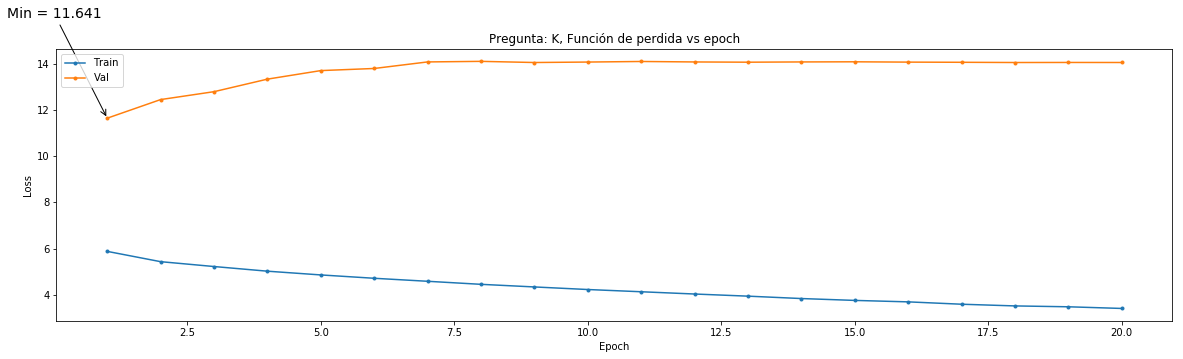

In [83]:
chart_loss(history_I, 20, "K")

In [84]:
def show_predictions_2(model, number_of_examples = 5):
    n_s = number_of_examples
    idx = np.random.choice(np.arange(Y_val.shape[0]), size=n_s, replace=False)
    Y_pred = model.predict_classes(X_val_tfidf[idx] )
    for i, n_sampled in enumerate(idx):
        text_input = [idx2word_s[p] for p in predict_words(X_val[n_sampled], data="source")]
        print("Texto source: ", ' '.join(text_input))
        text_real = [idx2word_t[p] for p in predict_words(Y_val[n_sampled,:,0], data="target")]
        print("Texto target real: ", ' '.join( text_real))
        text_sampled = [idx2word_t[p] for p in predict_words(Y_pred[i], data="target")]
        print("Texto target predicho: ", ' '.join(text_sampled))
        print('\n')
show_predictions_2(model)

Texto source:  this tv was made in china
Texto target real:  este fue en china #end
Texto target predicho:  la la la la la la #end


Texto source:  he has taken all this trouble for nothing
Texto target real:  se ha tomado tantas para nada #end
Texto target predicho:  no no nada nada nada nada #end


Texto source:  i am laughing at you
Texto target real:  me estoy riendo de ti #end
Texto target predicho:  estoy estoy #end


Texto source:  i believe in
Texto target real:  creo en el destino #end
Texto target predicho:  creo que en #end


Texto source:  i hate his parents
Texto target real:  odio a sus padres #end
Texto target predicho:  me padres padres padres #end


